In this example, we implement the method presented in [RKKM05] to compute a robust positively invariant polytope of a linear system under a disturbance bounded by a polytopic set.

We consider the example given in equation (15) of [RKKM05]:
$$x^+ =
\begin{bmatrix}
  1 & 1\\
  0 & 1
\end{bmatrix}x +
\begin{bmatrix}
  1\\
  1
\end{bmatrix} u
+ w$$
with the state feedback control $u(x) = -\begin{bmatrix}1.17 & 1.03\end{bmatrix} x$.
The controlled system is therefore
$$x^+ =
\left(\begin{bmatrix}
  1 & 1\\
  0 & 1
\end{bmatrix} -
\begin{bmatrix}
  1\\
  1
\end{bmatrix}
\begin{bmatrix}1.17 & 1.03\end{bmatrix}\right)x
+ w =
\begin{bmatrix}
  -0.17 & -0.03\\
  -1.17 & -0.03
\end{bmatrix}x
+ w.$$

[RKKM05] Sasa V. Rakovic, Eric C. Kerrigan, Konstantinos I. Kouramas, David Q. Mayne *Invariant approximations of the minimal robust positively Invariant set*. IEEE Transactions on Automatic Control 50 (**2005**): 406-410.

In [1]:
A = [1 1; 0 1] - [1; 1] * [1.17 1.03]

2×2 Array{Float64,2}:
 -0.17  -0.03
 -1.17  -0.03

The set of disturbance is the unit ball of the infinity norm.

In [2]:
using Polyhedra
Wv = vrep([[x, y] for x in [-1.0, 1.0] for y in [-1.0, 1.0]])

V-representation Polyhedra.PointsHull{Float64,Array{Float64,1},Int64}:
4-element iterator of Array{Float64,1}:
 [-1.0, -1.0]
 [-1.0, 1.0]
 [1.0, -1.0]
 [1.0, 1.0]

We will use the [CDDLib](https://github.com/JuliaPolyhedra/CDDLib.jl) for this example but feel free to use any other library from [this list of available libraries](https://juliapolyhedra.github.io/).

In [3]:
using CDDLib
W = polyhedron(Wv, CDDLib.Library())

Polyhedron CDDLib.Polyhedron{Float64}:
4-element iterator of Array{Float64,1}:
 [-1.0, -1.0]
 [-1.0, 1.0]
 [1.0, -1.0]
 [1.0, 1.0]

The $F_s$ function of equation (2) of [RKKM05] can be implemented as follows.

In [4]:
function Fs(s::Integer, verbose=1)
    @assert s ≥ 1
    F = W
    A_W = W
    for i in 1:(s-1)
        A_W = A * A_W
        F += A_W
        if verbose ≥ 1
            println("Number of points after adding A^$i * W: ", npoints(F))
        end
        removevredundancy!(F)
        if verbose ≥ 1
            println("Number of points after removing redundant ones: ", npoints(F))
        end
    end
    return F
end

Fs (generic function with 2 methods)

We can see below that only the V-representation is computed. In fact, no H-representation was ever computed during `Fs`. Computing $AW$ is done by multiplying all the points by $A$ and doing the Minkowski sum is done by summing each pair of points. The redundancy removal is carried out by CDD, internal LP solver.

In [5]:
Fs(10)

Number of points after adding A^1 * W: 16
Number of points after removing redundant ones: 8
Number of points after adding A^2 * W: 32
Number of points after removing redundant ones: 12
Number of points after adding A^3 * W: 48
Number of points after removing redundant ones: 16
Number of points after adding A^4 * W: 64
Number of points after removing redundant ones: 20
Number of points after adding A^5 * W: 80
Number of points after removing redundant ones: 24
Number of points after adding A^6 * W: 96
Number of points after removing redundant ones: 28
Number of points after adding A^7 * W: 112
Number of points after removing redundant ones: 31
Number of points after adding A^8 * W: 124
Number of points after removing redundant ones: 33
Number of points after adding A^9 * W: 132
Number of points after removing redundant ones: 31


Polyhedron CDDLib.Polyhedron{Float64}:
31-element iterator of Array{Float64,1}:
 [-1.29869, -2.59738]
 [-0.701305, 2.59738]
 [-0.958695, 1.74262]
 [-0.889305, 2.06938]
 [-0.910895, 1.97842]
 [-0.904505, 2.00638]
 [-0.906421, 1.9981]
 [-0.905944, 2.00017]
 [-0.906312, 1.99857]
 [-0.904871, 2.00481]
 [-0.909695, 1.98382]
 [-0.893505, 2.05318]
 [-0.946695, 1.81462]
 [-0.761305, 2.53738]
 [-1.29869, -0.597375]
 [1.29869, 0.597375]
 [0.761305, -2.53738]
 [0.946695, -1.81462]
 [0.893505, -2.05318]
 [0.909695, -1.98382]
 [0.904871, -2.00481]
 [0.906312, -1.99857]
 [0.905889, -2.00041]
 [0.905856, -2.00055]
 [0.906421, -1.9981]
 [0.904505, -2.00638]
  ⋮

The Figure 1 of [RKKM05] can be reproduced as follows:

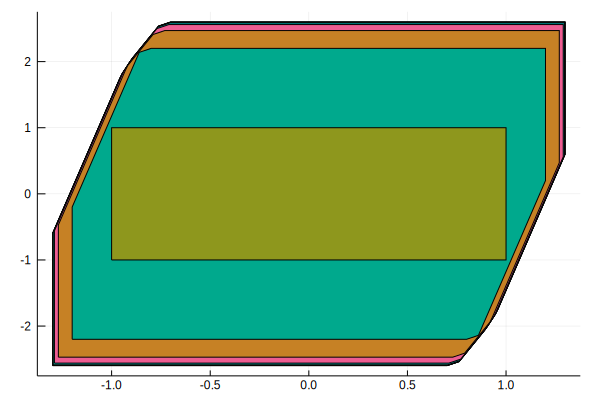

In [6]:
using Plots
plot()
for i in 10:-1:1
    plot!(Fs(i, 0))
end
# The cell needs to return the plot for it to be displayed
# but the `for` loop returns `nothing` so we add this dummy `plot!` that returns the plot
plot!()

Now, suppose we want to compute an invariant set by scaling $F_s$ by the appropriate $\alpha$.
In equation (11) of [RKKM05], we want to check whether $A^s W \subseteq \alpha W$ which is equivalent to $W \subseteq \alpha A^{-s} W$.

In [7]:
function αo(s)
    A_W = A^s \ W # This triggers the computation of the H-representation of W
    # A_W is H-represented
    hashyperplanes(A_W) && error("HyperPlanes not supported")
    return maximum([Polyhedra.support_function(h.a, W) / h.β for h in halfspaces(A_W)])
end

αo (generic function with 1 method)

We obtain $\alpha \approx 1.9 \cdot 10^{-5}$ like in [RKKM05].

In [8]:
α = αo(10)

1.9190700000000013e-5

The scaled set is is the following:

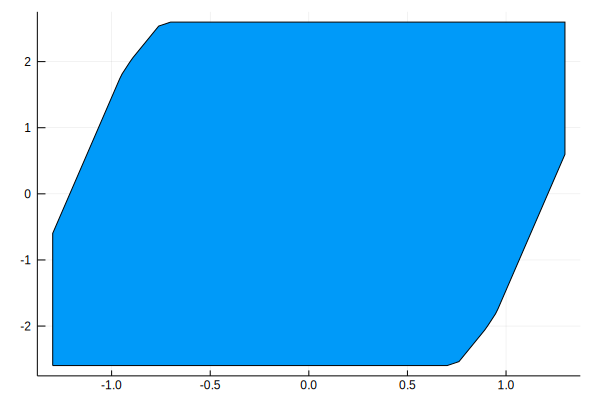

In [9]:
using Plots
plot((1 - α)^(-1) * Fs(10, 0))